# Keister Example

Author: Fred J. Hickernell + ChatGPT

#### Some LaTeX macros (hidden in math mode, will not render correctly in VS Code)
$
\newcommand{\vh}{\boldsymbol{h}}
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vz}{\boldsymbol{z}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\vU}{\boldsymbol{U}}
\newcommand{\vzero}{\boldsymbol{0}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cn}{\mathcal{N}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\cgp}{\mathcal{G}\!\mathcal{P}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Prob}{\mathbb{P}}
\newcommand{\bbone}{\mathbb{1}}
\newcommand{\reals}{\mathbb{R}}
\newcommand{\disc}{\operatorname{disc}}
\newcommand{\norm}[2]{{\left \lVert #1 \right \rVert}_{#2}}
$

#### Run this notebook in Juypter with the `conda qmcpy` environment or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/MATH565Fall2025/blob/main/notebooks/KeisterExample.ipynb?flush_cache=true)

In [1]:
# Colab-only setup
if "google.colab" in str(get_ipython()):
    !apt-get -y install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    !pip install git+https://github.com/QMCSoftware/QMCSoftware.git@develop

### Import needed packages and initialize some parameters

In [2]:
import sys
import time
from pathlib import Path
import numpy as np
from scipy import stats
import qmcpy as qp
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
REPO_ROOT = Path.cwd().resolve().parent  # Ensure repo root is on sys.path (for local 'classlib' and 'nbviz')
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
import classlib.nbviz as nb
nb.init(use_tex=True)     # styling, Tol cycle, CSS
colors, TINY = nb.TOL_BRIGHT, nb.TINY

## Original integral
This classical multivariate integration example takes the form
$$
\mu = \int_{\reals^d} \cos(\lVert \vt \rVert) \exp(-\lVert \vt \rVert^2) \, \dif \vt
$$
Let's plot it

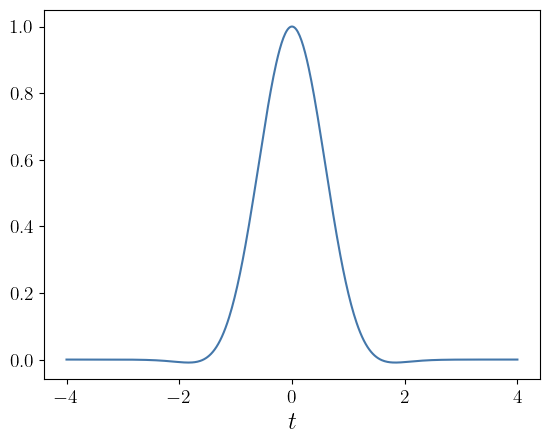

In [3]:
def Keister(t):
    norm2t = np.sum(t*t,axis=1)
    return np.cos(np.sqrt(norm2t))*np.exp(-norm2t)

t_plot = np.linspace(-4,4,500)[:, None]
plt.plot(t_plot,Keister(t_plot))
plt.xlabel("$t$");

## Variable transformations

Now we transform this integral to the unit cube

\begin{align*}
\mu &= \int_{\mathbb{R}^d} \cos(\lVert\boldsymbol{t}\rVert) \exp(-\lVert\boldsymbol{t}\rVert^2) \, \mathrm{d} \boldsymbol{t} \\
& \qquad \qquad  \boldsymbol{x} = \bigl(\Phi(at_1), \ldots,  \Phi(at_d) \bigr), \quad \Phi \text{ is the CDF of the standard normal} \\ 
& \qquad \qquad \mathrm{d} \boldsymbol{x} =  a^d \phi(at_1) \cdots  \phi(at_d) \, \mathrm{d} \boldsymbol{t} = \frac{a^d \exp( - a^2\lVert \boldsymbol{t} \rVert^2/2)}{(2\pi)^{d/2}} \,\mathrm{d} \boldsymbol{t} \\
& \qquad \qquad  \boldsymbol{t} = \bigl(\Phi^{-1}(x_1), \ldots,  \Phi^{-1}(x_d) \bigr)/a \\
\mu &= \int_{[0,1]^d} \frac{(2\pi)^{d/2}}{a^d} \cos\Bigl(\left\lVert\bigl(\Phi^{-1}(x_1), \ldots,  \Phi^{-1}(x_d) \bigr) \right\rVert  /a \Bigl)\\
&\qquad \qquad \times \exp\Bigl(-\frac{2-a^2}{2a^2}\left\lVert\bigl(\Phi^{-1}(x_1), \ldots,  \Phi^{-1}(x_d) \bigr) \right\rVert^{2} \Bigl) \, \mathrm{d} \boldsymbol{x}, \qquad (a^2 \le 2)
\end{align*}

In [4]:
def x_to_t(x,a):
    d = x.shape[1]
    t = stats.norm.ppf(x)/a 
    Jacobian = 1./ np.prod((a*stats.norm.pdf(a*t)), axis=1)
    return t, Jacobian

def f_keister(x, a):
    t, J = x_to_t(x, a)
    return Keister(t) * J 

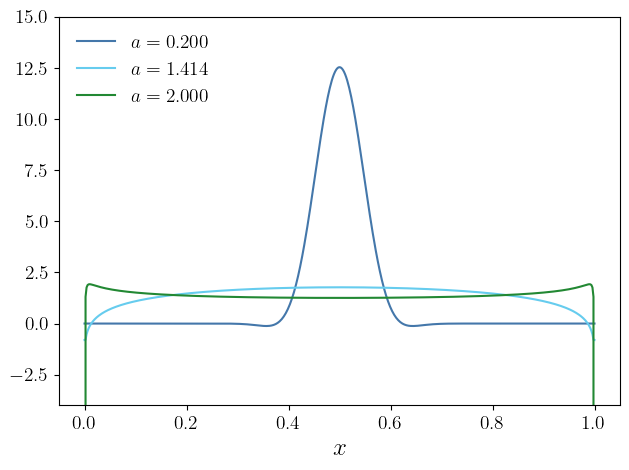

In [17]:
x_plot = np.linspace(TINY,1-TINY,500)[:, None]
#a_list = [0.2, 0.9, np.sqrt(2), 2, 10]
a_list = [0.2, np.sqrt(2), 2]
fig, ax = plt.subplots()
for a in a_list:
    ax.plot(x_plot, f_keister(x_plot,a), label=rf"$a = {a:2.3f}$")
ax.set_ylim(-4,15)
ax.set_xlabel("$x$")
ax.legend(loc="upper left")
fig.tight_layout()


## Accuracy of different variable transformations

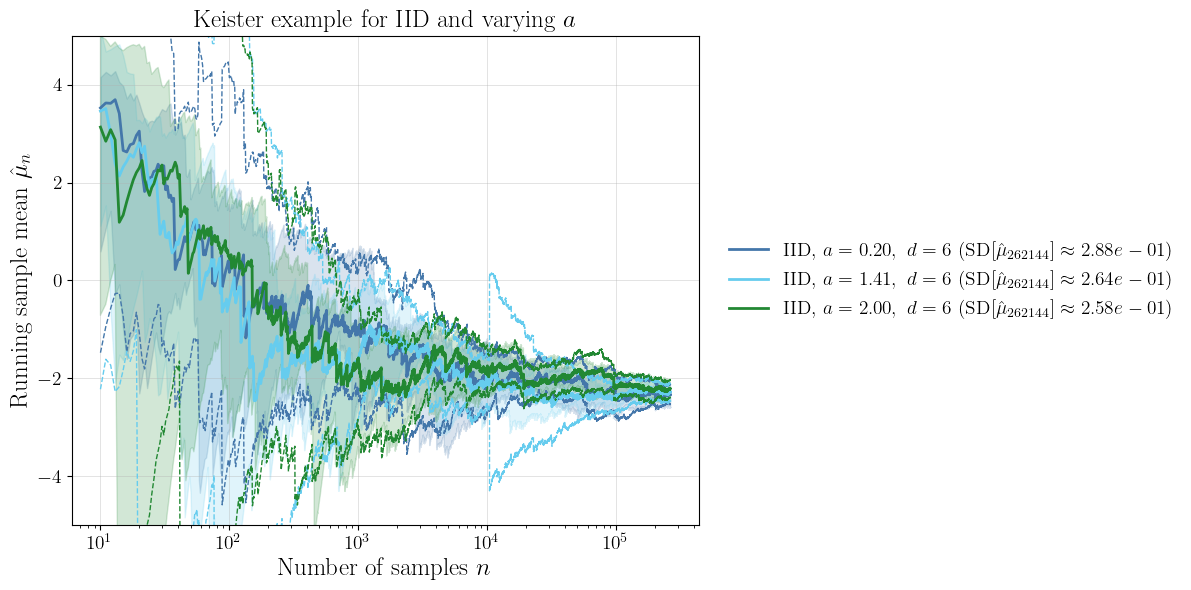

In [18]:
from classlib.plots import plot_middle_half_sample_mean, plot_multiple_middle_half_sample_means
n = 2**16
d = 6
configs = {
    # IID entries
    f"IID a={a:g}, d={d}": {
        "sampler": (lambda n : np.random.random((n, d))),
        "f":       (lambda x : f_keister(x, a)),
        "label":   rf"IID, $a={a:4.2f},\ d={d}$",
    }
    for a in a_list
}

ax, info = plot_multiple_middle_half_sample_means(
    configs,
    n_max=2**18,
    title="Keister example for IID and varying $a$",
    ylim=(-5,5)
)


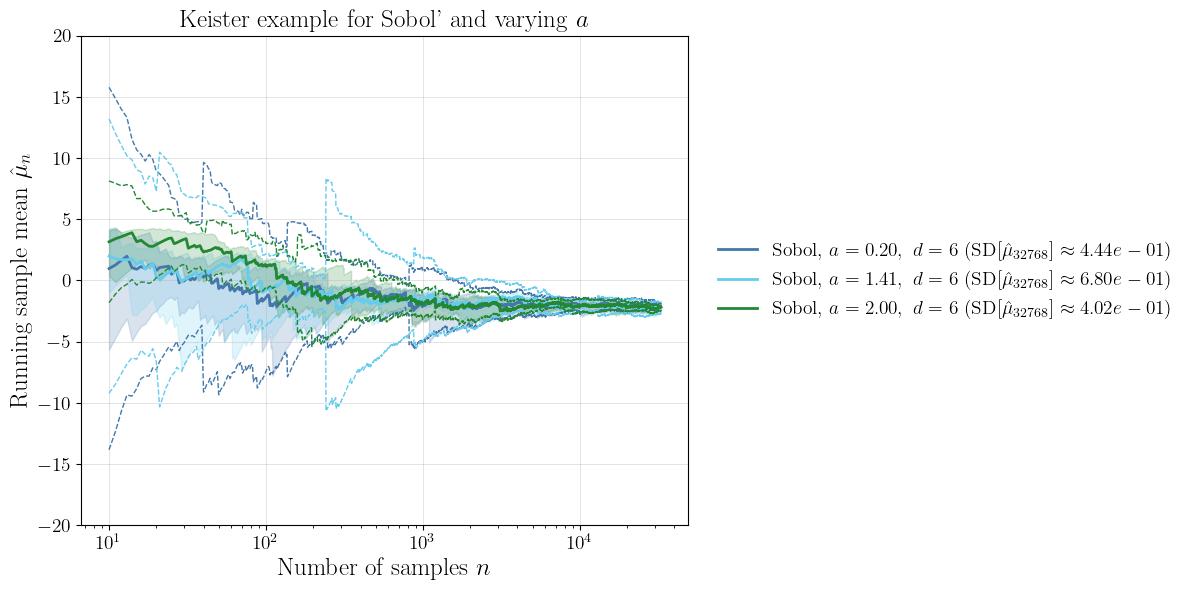

In [19]:
from classlib.plots import plot_middle_half_sample_mean, plot_multiple_middle_half_sample_means
n = 2**16
d = 6
configs = {
    # Sobol entries
    f"Sobol a={a:g}, d={d}": {
        "sampler": (lambda n : qp.Sobol(d).gen_samples(n)),
        "f":       (lambda x : f_keister(x, a)),
        "label":   rf"Sobol, $a={a:4.2f},\ d={d}$",
    }
    for a in a_list
}

ax, info = plot_multiple_middle_half_sample_means(
    configs,
    title="Keister example for Sobol' and varying $a$",
    ylim=(-20,20)
)
